In [1]:
import argparse, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import utils
import data.HCP_dataset_h5_arb as HCP_dataset
from tensorboardX import SummaryWriter
from itertools import product
from tqdm import tqdm

##### Model Imports ####
import torch
import torch.nn as nn
import data.utils_metrics as utils_met
import cucim.skimage.metrics as met
import torch.optim as optim
from torch.utils.data import DataLoader
from model import dmri_arb
#########################
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.enabled = False

print("PyTorch Version {}" .format(torch.__version__))
print("Cuda Version {}" .format(torch.version.cuda))
print("CUDNN Version {}" .format(torch.backends.cudnn.version()))

parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(16,16,16),
                    help="Block Size")
parser.add_argument("--test_block_size", type=tuple, default=(16,16,16),
                    help="Block Size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="Batch_size")
parser.add_argument("--sort", type=bool,
                    help="Sort Subject Ids")
parser.add_argument("--debug", type=bool,
                    help="Print additional input")
parser.add_argument("--preload", type=bool,
                    help="Preload data into memory")
parser.add_argument("--ret_points", type=bool, default=False,
                    help="return box point of crops")
parser.add_argument("--thres", type=float, default=0.6,
                    help="threshold for blk emptiness")
parser.add_argument("--offset", type=int, default=20,
                    help="epoch with scale (1,1,1)")
parser.add_argument("--gaps", type=int, default=20,
                    help="number of epochs of gap between each scale change")

args = list(parser.parse_known_args())[0]
args.preload = True
args.debug = False
args.dir = "/storage"
args.batch_size = 16
args.sort = True
args.cuda = True
cuda = args.cuda
device = torch.device('cuda' if cuda else 'cpu')
args.scale = (1,1,1)
# torch.cuda.set_device(7)
args.epochs = 100
args.gaps = 20
args.offset = 40
print(args)

number of common Subjects  171
PyTorch Version 2.1.0a0+29c30b1
Cuda Version 12.2
CUDNN Version 8904
Namespace(block_size=(16, 16, 16), test_block_size=(16, 16, 16), crop_depth=15, dir='/storage', batch_size=16, sort=True, debug=False, preload=True, ret_points=False, thres=0.6, offset=40, gaps=20, cuda=True, scale=(1, 1, 1), epochs=100)


7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 174

In [2]:

def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
        
    lr = torch.from_numpy(np.stack(x))
    pred = torch.from_numpy(np.stack(y))
    return lr,pred


def random_scale(seed = 0):
    np.random.seed(seed)
    sections = [0]
    sections.extend([i+args.offset for i in range(0,args.epochs-10,args.gaps)])
    scales = {i:np.around(np.random.uniform(1,2,3),decimals=2) for i in sections}
    scales[0] = (1,1,1)
    scales_txt = {j: ','.join([str(x) for x in scales[j]])  for j in scales.keys()}
    return sections,scales,scales_txt


In [3]:
ids = utils.get_ids()
ids.sort()

total_vols = 5

ids = ids[:total_vols]
dataset_hcp = HCP_dataset
ids = dataset_hcp.load_data(args.dir,ids)
print("total vols:",len(ids))

####
train_vols = int(len(ids) * 0.70)
####
print(f'train vols:{len(ids[:train_vols])} test_vols:{len(ids[train_vols:])}')

testing_dataset = dataset_hcp.hcp_data_test_recon(args,ids[train_vols:],test = True)
# training_dataset = dataset_hcp.hcp_data(args,ids[:train_vols])
print(len(testing_dataset))

total vols: 5
train vols:3 test_vols:2
2


In [4]:
x = testing_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape,x[4].shape,x[5].shape)

(249, 16, 16, 16, 7) (173, 207, 173) (173, 207, 173) (173, 207, 173, 3) (249, 6) (173, 207, 171)


In [5]:

def recon(x,lr,vol_size):
    num_blk = x.shape[0]
    vol = np.empty(shape=vol_size)
    print(num_blk)
    for i in range(num_blk):
        vol[lr[i][0]:lr[i][1]+1,lr[i][2]:lr[i][3]+1,lr[i][4]:lr[i][5]+1,...] = x[i,...]
    return vol
    

def resize_test(data):
    x,y,z,mask = [],[],[],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
        z.append(data[i][4])
        mask.append(data[i][5])
    lr = torch.from_numpy(np.stack(x)).squeeze()
    pred = torch.from_numpy(np.stack(y)).squeeze()
    pnt = torch.from_numpy(np.stack(z)).squeeze()
    mask = torch.from_numpy(np.stack(mask)).squeeze()
    return lr,pred,pnt,mask


In [6]:
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize_test)

In [8]:
x = next(iter(testing_data_loader))

In [10]:
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

torch.Size([263, 16, 16, 16, 7]) torch.Size([173, 207, 173, 5]) torch.Size([263, 6]) torch.Size([173, 207, 171])


In [11]:
model = dmri_arb.DMRI_SR()
model.set_scale((1,1,1))
model = model.to('cuda')

In [12]:
model.eval()
for iteration, (lr_tensor, hr_tensor,pnts,mask) in enumerate(testing_data_loader, 1):
#         pbar.update(1)
        if args.cuda:
            lr_tensor = lr_tensor.to(device)
            hr_tensor = hr_tensor.to(device)
            lr_tensor = torch.permute(lr_tensor, (0,4,1,2,3))
            with torch.no_grad():
                pred_tensor = model(lr_tensor)
            
        pred_tensor = torch.permute(pred_tensor, (0,2,3,4,1))

In [14]:
pred_tensor.shape

torch.Size([263, 16, 16, 16, 5])

In [ ]:
pred_tensor.shape

In [ ]:
torch.cuda.empty_cache()

In [ ]:
x[2].shape,x[3].shape

In [21]:
r = recon(pred_tensor.cpu(),x[2],vol_size = (173,201,171,5))

263


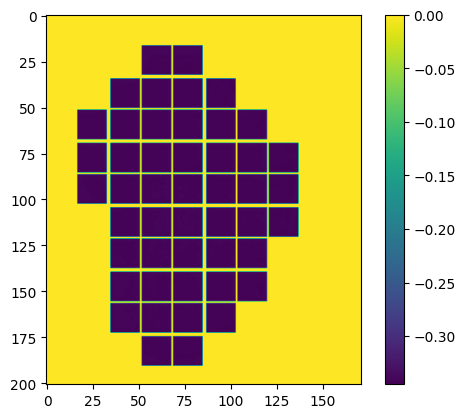

In [23]:
plt.imshow(r[70,:,:,0])
plt.colorbar()

In [37]:
mask = x[5][...,np.newaxis]

In [38]:
mask.shape

(173, 207, 171, 1)

In [41]:
r*mask

ValueError: operands could not be broadcast together with shapes (173,207,173,7) (173,207,171,1) 

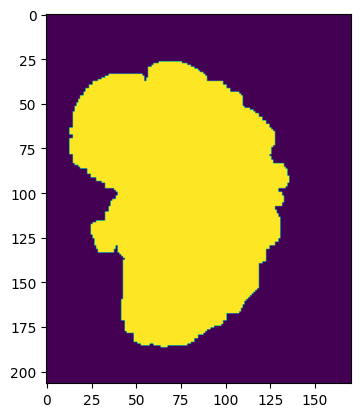

In [33]:
plt.imshow(x[5][70,:,:])

In [69]:
print(x[0].shape,x[1].shape)

torch.Size([263, 16, 16, 16, 7]) torch.Size([173, 207, 173, 5])
